# Registration

## Correct for rigid/non-rigid movement

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd

import mesmerize_core as mc
import numpy as np
import tifffile
from matplotlib import pyplot as plt

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import lbm_caiman_python as lcp

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### (optional): View hardware information

In [15]:
!pip install cloudmesh-cmd5
!cms help # dont forget to call it after the install as it sets some defaults
!cms sysinfo


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


*** No help on # dont forget to call it after the install as it sets some defaults
+------------------+------------------------------------------------------------------------------------+
| Attribute        | Value                                                                              |
+------------------+------------------------------------------------------------------------------------+
| cpu              |                                                                                    |
| cpu_cores        | 24                                                                                 |
| cpu_count        | 32                                                                                 |
| cpu_threads      | 32                                                                                 |
| date             | 2024-11-26 16:29:03.580714                                                         |
| frequency        | scpufreq(current=3200.0, min=0.0, max=3200.0)   

### Data path setup

We set 2 path variables:

1. `data_path` : input, path where you saved the output from the assembly step
2. `batch_path` : results, can be anywhere you please, must end in .pickle

```{note}
This notebook assumes you saved scans as TIFF with `join_contiguous=True` so filenames are `plane_N.tiff`
The process for `join_contiguous=False` is the same, but with the roi attached to the filename `plane_N_roi_M`.
```
To simplify data management, we put our batch_path (which stores results) in the same directory as our raw data.

In [16]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out2'  # where the output files from the assembly step are located
batch_path = data_path / 'batch.pickle'

In [20]:
tiff_files = [x for x in Path(data_path).glob('*.tif*')]
tiff_files

[PosixPath('/home/flynn/caiman_data/out2/plane_21.tiff'),
 PosixPath('/home/flynn/caiman_data/out2/plane_1.tiff'),
 PosixPath('/home/flynn/caiman_data/out2/plane_16.tiff')]

### Load a data file to examine

In [30]:
file = tiff_files[1]
data = tifffile.imread(file)
data.shape

(1000, 600, 576)

## View metadata

`lcp.get_metadata(filepath)` works on raw scanimage files and files processed through `lcp.save_as()`

In [31]:
metadata = lcp.get_metadata(file)
metadata

{'image_height': 2478,
 'image_width': 145,
 'num_pages': 51900,
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'shape': [51900, 2478, 145],
 'num_planes': 30,
 'num_rois': 4,
 'num_frames': 1730.0,
 'frame_rate': 9.60806,
 'fov': [150, 600],
 'pixel_resolution': [1.04, 1.0],
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'num_lines_between_scanfields': 24,
 'center_xy': [-1.428571429, 0],
 'line_period': 4.15652e-05,
 'size_xy': [0.9523809524, 3.80952381],
 'objective_resolution': 157.5}

## Registration parameters

Here’s a markdown table describing the parameters:

| Parameter               | Description                                                                                     | Value/Default                  |
|-------------------------|-------------------------------------------------------------------------------------------------|--------------------------------|
| `dxy`                  | Spatial resolution (pixel size in micrometers).                                                 | `dxy` (from metadata)           |
| `fr`                   | Frame rate of the video (frames per second).                                                    | `fr` (from metadata)            |
| `max_shifts`           | Maximum allowed rigid shift in pixels for motion correction.                                     | `(int(10/dxy), int(10/dxy))`   |
| `strides`              | Size of patches for motion correction.                                                          | `[48, 48]`                     |
| `overlaps`             | Overlap between patches for motion correction.                                                  | `[24, 24]`                     |
| `max_deviation_rigid`  | Maximum allowed deviation for patches relative to rigid shifts.                                  | `3`                            |
| `border_nan`           | How to handle border values during motion correction.                                            | `'copy'`                       |
| `pw_rigid`             | Flag indicating whether to perform piecewise rigid motion correction.                            | `False`                        |
| `gSig_filt`            | Size of the Gaussian filter for smoothing the motion correction process.                         | `(3, 3)`                       |
| `shifts_opencv`        | Flag to use bicubic interpolation for motion correction.                                         | `True`                         |

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

### Parameters from metadata

```{note}
We want our parameters to physically make sense. 
For example, `max_shifts` is the maximum allowed *rigid* shift in pixels.
We don't want to shift any pixels more than a full neuron or we will introduce artifacts between frames.
```

In [32]:
dxy = metadata['pixel_resolution']
print(f"Pixel resolution: {dxy[0]} um/px, {dxy[1]} um/px")

Pixel resolution: 1.04 um/px, 1.0 um/px


In [33]:
# note this is only for a single ROI
fov = metadata['fov']
print(f"Field of View: {fov[0]}px, {fov[1]}px")

Field of View: 150px, 600px


In [34]:
fr = metadata['frame_rate']
print(f"Frame rate: {fr} Hz")

Frame rate: 9.60806 Hz


## Preview data with scalebars

`plot_data_with_scalebars` will give you 3 images, at 5, 10 and 20 um. Take note of the approximate size of the neurons in your data.

You can use a single frame:

```python
plot_with_scalebars(data[0, :, :], np.mean(dxy))
```
A mean image:

```python
plot_with_scalebars(np.mean(data, axis=0), np.mean(dxy))
```

or, the maximum-projection image as displayed below.


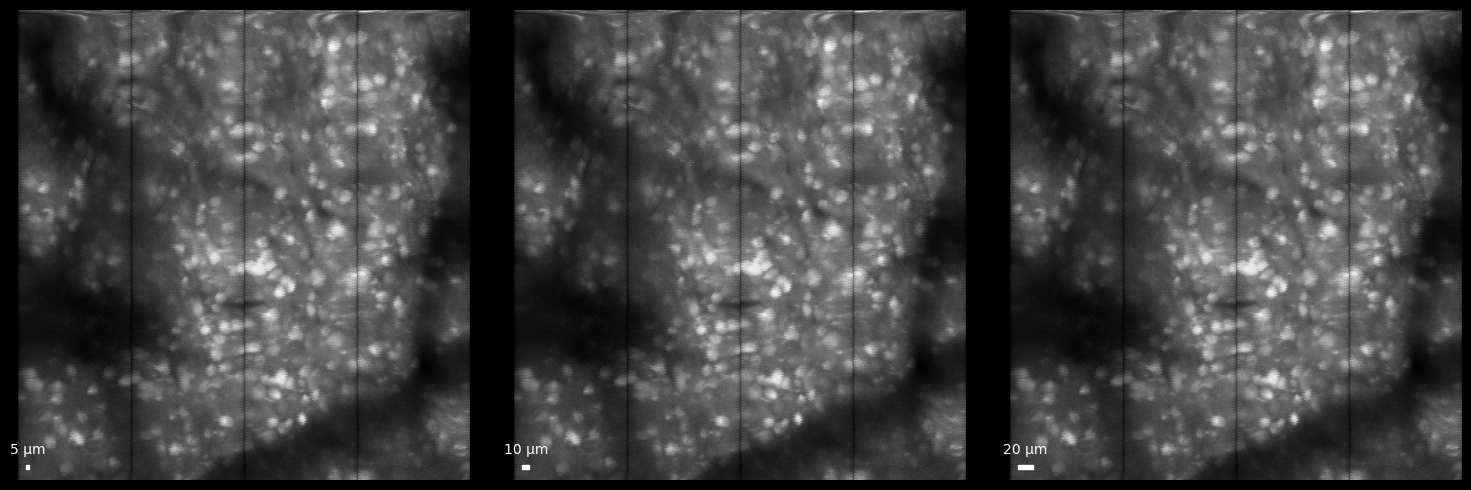

In [36]:
from lbm_caiman_python import plot_with_scalebars

# plot_with_scalebars(data[0, :, :], np.mean(dxy))
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))

## Visualize patches

The `generate_patch_view` function divides the image into patches the same way CaImAn does internally.

Increasing / decreasing the `target_patch_size` and `overlap_fraction` parameters to examine the effect of different stride/overlap values displayed in the title. 

In general, you want patches to encompass at least the size of a full neuron and generally 2-3x the neuron size.


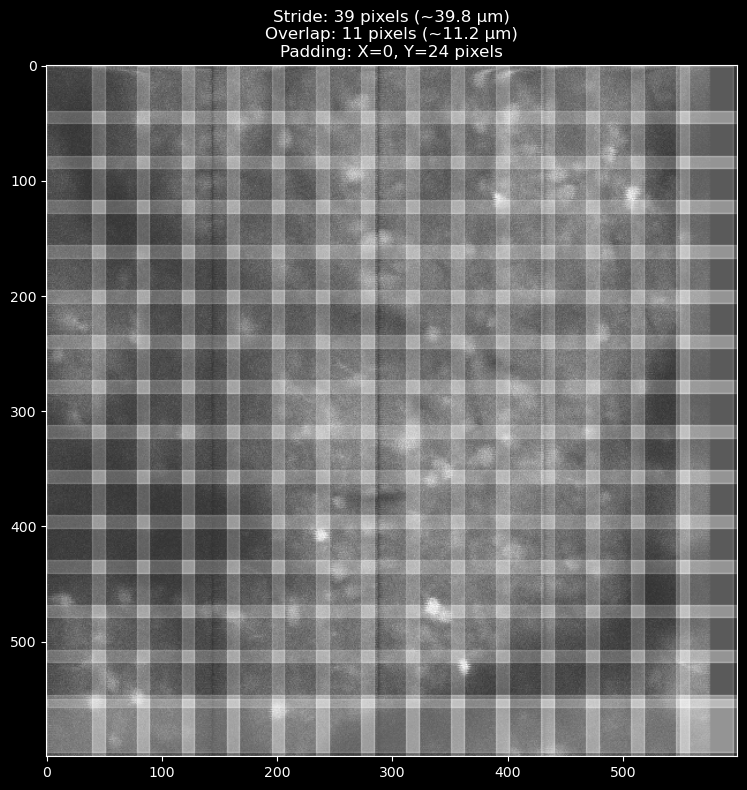

In [37]:
from lbm_caiman_python import generate_patch_view
# this function assumes a square pixel resolution, so take the mean
fig, ax = generate_patch_view(data[0, :, :], pixel_resolution=np.mean(dxy), target_patch_size=40, overlap_fraction=0.3) # defaults
plt.show()

## Create the parameters we pass to CaImAn

The above patch view looks good, so we use those values in our parameters dictionary.

You *can* also include segmentation parameters in this dictionary if you wish. This is *not recommmended* as several parameters share similar names yet perform different actions. i.e:
-  `stride` and `gSig_filt` parameters are for registration
-  `strides` for `gSig` are parameters for segmentation

In [38]:
max_shift = 30                                  # pixels
max_shifts = (int(max_shift), int(max_shift))   # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                       # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True                  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'dxy': dxy,
        'fr': fr,
        'max_shifts': max_shifts, # make sure its a tuple/list of integers 
        'strides': [39, 39],
        'overlaps': [11, 11],
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': (3, 3),
    },
}

## Run registration with `mesmerize-core`

See the mesmerize-core [utility docs](https://mesmerize-core.readthedocs.io/en/latest/api/functions.html) for more information on batch creation.


### Create or load a batch set

```{warning}
In the below if-else clause, be careful if you expect a batch to exist, a typo can be deceiving!
```

In [39]:
# Create or load a batch results file
# To overwrite:
# df = mc.create_batch(batch_path, remove_existing=True)

if not batch_path.exists():
    df = mc.create_batch(batch_path)
else:
    df = mc.load_batch(batch_path)

# tell mesmerize where the raw data is
mc.set_parent_raw_data_path(data_path)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid


### Add an item to the batch

A "batch item" consists of:
* algorithm to run, `algo` 
    - currently: mcorr, cnmf, cnmfe
* input movie to run the algorithm on, `input_movie_path`
    - can be string or dataframe row
* parameters for the specified algorithm, `params`
* a name for you to keep track of things `item_name`
    - can be anything

In [40]:
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=file,
    params=mcorr_params,
    item_name=f'mcorr',  
)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (30, 30), 'strides': (39, 39), 'overlaps': (11, 11), 'max...",None,2024-12-01T17:41:16,None,None,None,0393cf1f-f193-4fa5-9707-188c891dc68c


# First registration run

```{note}
On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.
For this reason, on windows you need to reload the dataframe:
```
```python
df=df.caiman.reload_from_disk()
df
```

If you ever get errors like 

```python
TypeError: NoneType is not subscriptable
```
**This likely means you need to reload the dataframe**.

In [41]:
df.iloc[0].caiman.run()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


finished computing correlation image


<Popen: returncode: 0 args: '/home/flynn/caiman_data/out2/0393cf1f-f193-4fa5...>

In [43]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (30, 30), 'strides': (39, 39), 'overlaps': (11, 11), 'max...",{'mean-projection-path': 0393cf1f-f193-4fa5-9707-188c891dc68c/0393cf1f-f193-4fa5-9707-188c891dc68c_mean_projection.n...,2024-12-01T17:41:16,2024-12-01T17:42:16,54.1 sec,None,0393cf1f-f193-4fa5-9707-188c891dc68c


### Check for errors in outputs

In the table header **outputs**, you should see 

```python
{'mean-projection-path': ...}
```
If you see instead:

```python
{'success': False, ...}
```

Run the below cell to evaluate the error message.

In [44]:
import pprint
pprint.pprint(df.iloc[-1].outputs["traceback"])

None


## Evaluate motion correction outputs with `mesmerize-core` API 

mesmerize-core offers an easy [API](https://mesmerize-core.readthedocs.io/en/latest/api/mcorr.html) to retrieve results from the batch dataframe.

In [45]:
index = 0

# get the motion corrected movie memmap
mcorr_movie = df.iloc[0].mcorr.get_output()
mcorr_shifts = df.iloc[0].mcorr.get_shifts()

# path to the mcorr memmap if you ever need it
mcorr_memmap_path = df.iloc[0].mcorr.get_output_path()

# mean projection, max and std projections are also available
mean_proj = df.iloc[0].caiman.get_projection("mean")

# the input movie, note that we use `.caiman` here instead of `.mcorr`
input_movie = df.iloc[0].caiman.get_input_movie()

### Side-by-side with `fastplotlib`

Its helpful to zoom into specific locations of your images to see improvements.

RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='900px')
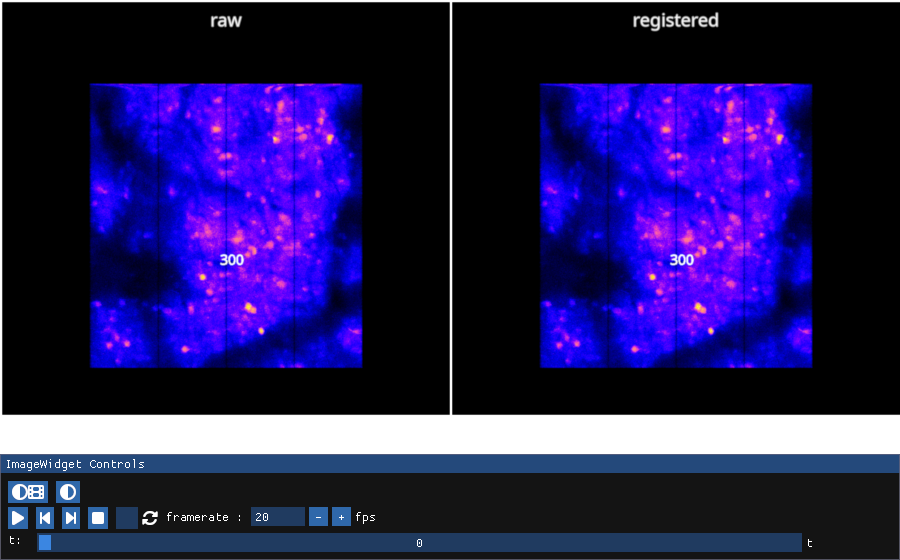

No such comm: 3c78dee3e44a41e8b694fa20f61edb6e
No such comm: 3c78dee3e44a41e8b694fa20f61edb6e


In [53]:
import fastplotlib as fpl

mcorr_iw = fpl.ImageWidget(
    data=[input_movie, mcorr_movie],
    names=['raw', 'registered'],
    cmap="gnuplot2",
    window_funcs={},
    figure_kwargs={"size": (900, 560)},
    histogram_widget=False, # helps keep plots close together 
)
mcorr_iw.show()

In [54]:
mcorr_iw.close()

In [ ]:
from ipywidgets import Tab, Text, Button, VBox, interact_manual, interactive
@interact_manual(parent_path=str(parent_path), batch_path=str(batch_path))
def start_widget(parent_path, batch_path):
    mc.set_parent_raw_data_path(parent_path)

    df = mc.load_batch(batch_path)

    tab = Tab()

    # mcorr_container = df.mcorr.viz()
    mcorr_container = df.mcorr.viz(start_index=0)

    tab.children = [mcorr_container.show()]
    tab.titles = ["mcorr"]
    display(tab)

# Registration Grid Search (if you need it!)

More runs with varying parameters, stored on disk in the dataframe batch.pickle

In [37]:
# copy the mcorr_params2 dict to make some changes
# some variants of max_shifts
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=tiff_files[0],
            params=new_params,
            item_name=tiff_files[0].stem,  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",{'mean-projection-path': 'e7d6ee76-b236-4fdc-a978-da72abb5b6cd/e7d6ee76-b236-4fdc-a978-da72abb5b6cd_mean_projection....,2024-09-12T17:38:56,2024-09-13T00:40:44,41.1 sec,None,e7d6ee76-b236-4fdc-a978-da72abb5b6cd
1,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_deviation_rigi...",None,2024-09-13T00:53:41,None,None,None,1ea42667-276d-486f-a63e-0cbbf0744ca8
2,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (2, 2), 'strides': (64, 64), 'overlaps': (32, 32), 'max_deviation_ri...",None,2024-09-13T00:53:41,None,None,None,9aa2b5f3-14f0-4fbb-bfed-907c50969918
3,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (32, 32), 'strides': (12, 12), 'overlaps': (6, 6), 'max_deviation_ri...",None,2024-09-13T00:53:41,None,None,None,703926de-8926-4613-a9e6-abe5c0cbedeb
4,mcorr,extracted_plane_1,tiff/extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max_deviation_...",None,2024-09-13T00:53:41,None,None,None,c0685366-5d8c-4dec-b607-44265f5033cc


In [38]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

/home/mbo/caiman_data_org/animal_01/session_01/1ea42667-276d-486f-a63e-0cbbf0744ca8.runfile
starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/animal_01/session_01/9aa2b5f3-14f0-4fbb-bfed-907c50969918.runfile


2024-09-13 00:53:48.814012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:53:48.814044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:53:48.814390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:53:48.817005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/animal_01/session_01/703926de-8926-4613-a9e6-abe5c0cbedeb.runfile


2024-09-13 00:55:32.175065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:55:32.175096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:55:32.175457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:55:32.178227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/animal_01/session_01/c0685366-5d8c-4dec-b607-44265f5033cc.runfile


2024-09-13 00:56:14.293577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:56:14.293616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:56:14.294074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:56:14.297998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
/home/mbo/caiman_data_org/animal_01/session_01/tiff/extracted_plane_1.tif
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image



2024-09-13 00:58:00.267324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 00:58:00.267357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 00:58:00.267712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 00:58:00.270576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t


# Distinguishing parameter variants

We can see that there are many parameter variants, but it is not easy to see the differences in parameters between the rows that have the same `item_name`.

We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`

In [7]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

,overlaps,max_shifts,strides
0,"[24, 24]","(10, 10)","[48, 48]"
1,"(6, 6)","(2, 2)","(12, 12)"
2,"(32, 32)","(2, 2)","(64, 64)"
3,"(6, 6)","(32, 32)","(12, 12)"
4,"(32, 32)","(32, 32)","(64, 64)"


# Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [11]:
plane = 1

df = df.caiman.reload_from_disk()

# first item is just the raw movie

movies = [df.iloc[0].caiman.get_input_movie()]

subplot_names = ["raw"]

means = [df.iloc[0].caiman.get_projection("mean")]

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():

    if row.algo != 'mcorr':
        continue

    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]

    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")

    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))

ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape


In [15]:
iw_zfish = fpl.ImageWidget(
    data=[movies[0], movies[1]],
    names=['Raw', 'Corrected'],
    cmap="gray",
    histogram_widget=False
)
iw_zfish.show()

RFBOutputContext()

/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  | attribute  | type        | description                                   |


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

ERROR:wgpu:Draw error: Validation Error (7)
ERROR:wgpu:Present error: present() is called without a preceeding call to get_c… (7)
ERROR:wgpu:Draw error: Validation Error (8)
ERROR:wgpu:Present error: present() is called without a preceeding call to get_c… (8)
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  | attribute  | type        | description                                   |


In [23]:
napari.view_image(movies[0], name=subplot_names[0])


# mcorr_movie = df.iloc[0].mcorr.get_output()
# mcorr_movie2 = df.iloc[-1].mcorr.get_output()
# corr, pnr = correlation_pnr(mcorr_movie, swap_dim=False)
# corr2, pnr2 = correlation_pnr(mcorr_movie2, swap_dim=False)

Viewer(camera=Camera(center=(0.0, 299.5, 279.5), zoom=1.3079464285714284, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(864.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=1729.0, step=1.0), RangeTuple(start=0.0, stop=599.0, step=1.0), RangeTuple(start=0.0, stop=559.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(864.0, 299.0, 279.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'raw' at 0x7f202c877f50>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f22ca409d

In [47]:
import napari
viewer = napari.Viewer()
viewer.add_image(mcorr_movie, name=f'plane_2_a')
viewer.add_image(mcorr_movie2, name=f'plane_2_b')
viewer.add_image(corr, name="Mean Correlation")
viewer.add_image(corr2, name="Mean Correlation2")

<Image layer 'Mean Correlation2' at 0x7fe77fe5cad0>

In [ ]:
napari.view_image(df.iloc[0].mcorr.get_output()[::2, ...])
napari.current_viewer().add_image(df.iloc[0].caiman.get_input_movie()[::2, ...])

ERROR:tifffile:<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape


<Image layer 'pnr' at 0x7f4cd3c0cc10>

## Correlation metrics

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [5]:
row_index = i

mean_proj = df.iloc[i].caiman.get_projection("mean")
max_proj = df.iloc[i].caiman.get_projection("max")
std_proj = df.iloc[i].caiman.get_projection("std")
corr_image = df.iloc[i].caiman.get_corr_image()
# viewer.add_image(mcorr_movie, rgb=False, multiscale=False)
# viewer.add_image(input_movie['plane_1'], rgb=False, multiscale=False)

viewer = napari.Viewer()
viewer.add_image(mean_proj)
viewer.add_image(std_proj)
viewer.add_image(max_proj)
viewer.add_image(corr_image)

NameError: name 'i' is not defined

## Pixel Shifts

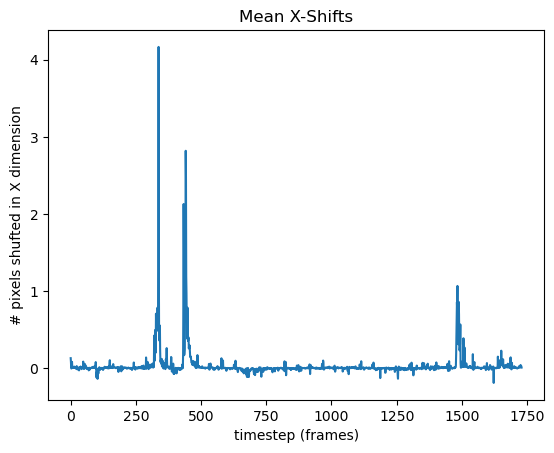

In [6]:
row_idx = 0

shifts = df.iloc[row_idx].mcorr.get_shifts()
shifts = shifts[1]
shiftsx = [x[0] for x in shifts]
shiftsy = [x[1] for x in shifts]
shiftsx_mean = [np.mean(x) for x in shiftsx]
shiftsy_mean = [np.mean(y) for y in shiftsy]
##%%
xr = list(range(1730))
plt.plot(xr, shiftsx_mean)
plt.title('Mean X-Shifts') # TODO: std error bars, napari layer
plt.xlabel("timestep (frames)")
plt.ylabel("# pixels shufted in X dimension")
plt.show()

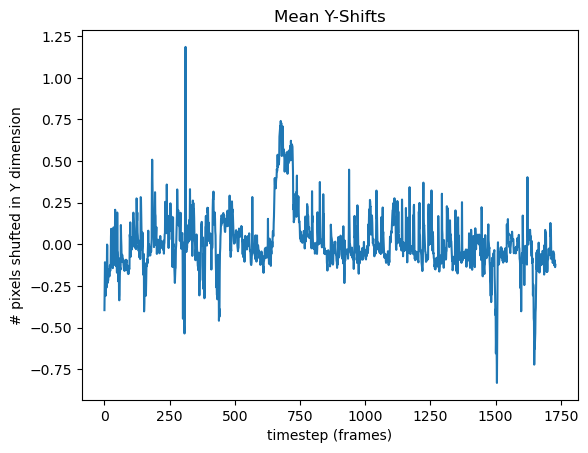

In [7]:
xr = list(range(1730))

plt.title('Mean Y-Shifts') # TODO: std error bars, napari layer
plt.xlabel("timestep (frames)")
plt.ylabel("# pixels shufted in Y dimension")
plt.plot(xr, shiftsy_mean)

# Optional, cleanup DataFrame

Use the index that works best and all other items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

**Note:** On windows calling `remove_item()` will raise a `PermissionError` if you have the memmap file open. The workaround is to shutdown the current kernel and then use `df.caiman.remove_item()`. For example, you can keep another notebook that you use just for cleaning unwanted mcorr items.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

Indices are always reset when you use `caiman.remove_item()`. UUIDs are always preserved.

In [14]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2/5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2_mean_projection....,2024-09-09T14:50:33,2024-09-10T09:55:53,42.42 sec,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 'aab79e23-ebcc-45cb-a12b-6f7e3eae935c/aab79e23-ebcc-45cb-a12b-6f7e3eae935c_mean_projection....,2024-09-09T14:50:49,2024-09-10T09:57:13,42.87 sec,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c
2,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
3,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T10:46:06,None,None,None,00dc740c-7cf4-4cbb-b239-4cd8fc0439a2
4,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T11:05:25,None,None,None,0b04ece1-0bf1-4d76-8688-f4091e06ca2b


In [15]:
rows_keep = [2]
for i, row in df.iterrows():
    if i not in rows_keep:
        df.caiman.remove_item(row.uuid, safe_removal=False)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02


In [16]:
df.caiman.save_to_disk()

Name,/mov
Type,zarr.core.Array
Data type,float64
Shape,"(1730, 584, 544)"
Chunk shape,"(52, 584, 544)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4396912640 (4.1G)
No. bytes stored,1118784685 (1.0G)


## Evaluate Results: Optical Flow

In [20]:
import caiman as cm

In [9]:
# fnames = [df.iloc[0].mcorr.get_]
# fnames = [str(df.iloc[0].mcorr.get_output_path())]
fnames = str(movie_path)
fnames_rig = str(df.iloc[0].mcorr.get_output_path())

#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(movie[1,:,:].shape, 2 * 2) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

NameError: name 'movie' is not defined

In [27]:
%%capture

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)


In [30]:
tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    fnames_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

# tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
#     mc.fname_tot_els[0], final_size[0], final_size[1],
#     swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [62]:
fpath = cm.paths.fname_derived_presuffix(str(fnames), 'metrics', swapsuffix='npz')
fpath

'/home/mbo/caiman_data_org/animal_01/session_01/plane_1_metrics.npz'

In [8]:
##%% plot the results of Residual Optical Flow
fls = [cm.paths.fname_derived_presuffix(str(fnames), 'metrics', swapsuffix='npz'), cm.paths.fname_derived_presuffix(str(fnames_rig), 'metrics', swapsuffix='npz')]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['raw','corrected',]):
    print('fl')
    if Path(fl).suffix == '.npz':
        with np.load(str(fl)) as ld:
            print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
                ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
            plt.subplot(len(fls), 3, 1 + 3 * cnt)
            plt.ylabel(metr)
            try:
                mean_img = np.mean(cm.load(fl[:-12] + '.tif'))[12:-12, 12:-12]
            except:
                try:
                    mean_img = np.mean(
                        cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
                except:
                    try:
                        mean_img = np.mean(
                            cm.load(fl[:-12] + '.hdf5'), 0)[12:-12, 12:-12]
                    except:
                        try:
                            mean_img = np.mean(cm.load(fl[:-12] + '.zarr'), 0)[12:-12, 12:-12]
                        except:
                            print(fl[:-12] + '.zarr')



            lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
            plt.imshow(mean_img, vmin=lq, vmax=hq)
            plt.title('Mean Optical Flow')
            plt.subplot(len(fls), 3, 3 * cnt + 2)
            plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
            plt.title('Corr image')
            plt.subplot(len(fls), 3, 3 * cnt + 3)
            flows = ld['flows']
            plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
            plt.colorbar()


            lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
            plt.imshow(mean_img, vmin=lq, vmax=hq)
            plt.title('Mean Optical Flow')
            plt.subplot(len(fls), 3, 3 * cnt + 2)
            plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
            plt.title('Corr image')
            plt.subplot(len(fls), 3, 3 * cnt + 3)
            flows = ld['flows']
            plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
            plt.colorbar()

NameError: name 'cm' is not defined

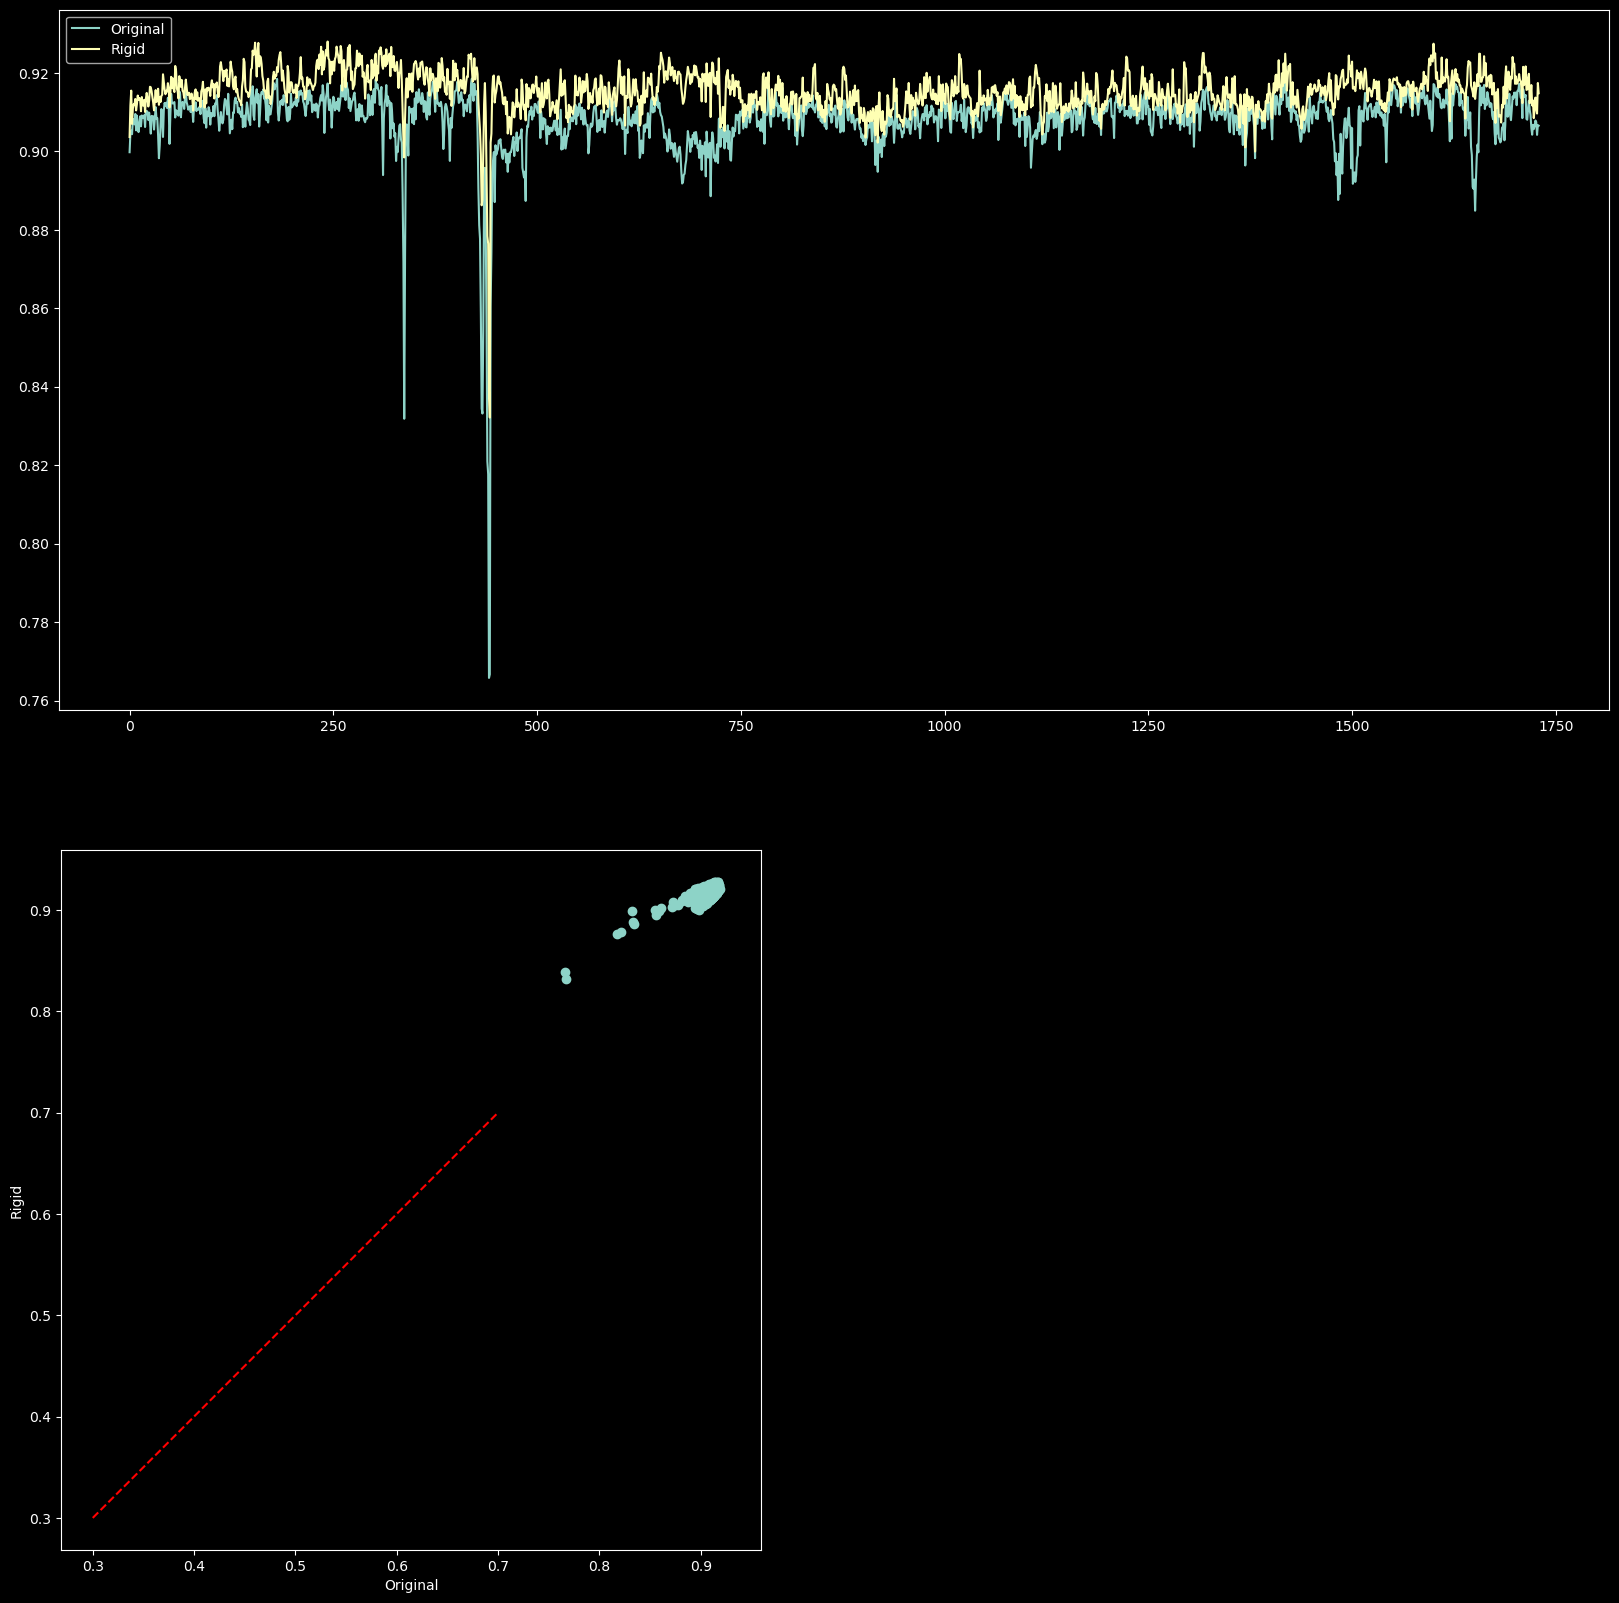

In [71]:
plt.figure(figsize = (20,20))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig);
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original');
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');

## Apply registration using the same parameters to the remaining z-planes

In [31]:
# # Add a "batch item" to the DataFrame this is the combination of:
# * algorithm to run, `algo`
# * input movie to run the algorithm on, `input_movie_path`
# * parameters for the specified algorithm, `params`
# * a name for you to keep track of things, usually the same as the movie filename, `item_name`
for i in range(2, 30):
    movie = parent_path / 'tiff' / f'extracted_plane_{i}.tif'
    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=movie,
        params= df.iloc[0].params,
        item_name=f'plane_{i}',  # filename of the movie, but can be anything
    )

In [34]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,extracted_plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328_mean_projection.n...,2024-09-26T11:56:54,2024-09-26T12:02:55,77.3 sec,None,b32f41bf-a9a5-4965-be7c-e6779e854328
1,cnmf,cnmf_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': a057e39e-a2df-41d3-8217-83c9cd7ffb6d\a057e39e-a2df-41d3-8217-83c9cd7ffb6d_mean_projection.n...,2024-09-26T16:26:20,2024-09-26T16:28:48,143.18 sec,None,a057e39e-a2df-41d3-8217-83c9cd7ffb6d
2,cnmf,cnmf_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': 0d8d3234-eab7-4f90-9405-53a2ad7917dc\0d8d3234-eab7-4f90-9405-53a2ad7917dc_mean_projection.n...,2024-10-01T12:09:56,2024-10-01T12:26:42,996.44 sec,None,0d8d3234-eab7-4f90-9405-53a2ad7917dc
3,mcorr,plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': c220fb8a-cef9-4784-91a2-84f33d760b75\c220fb8a-cef9-4784-91a2-84f33d760b75_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:28:06,83.34 sec,None,c220fb8a-cef9-4784-91a2-84f33d760b75
4,mcorr,plane_2,tiff\extracted_plane_2.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': ecdbaa07-8893-4352-8658-19a8357306b8\ecdbaa07-8893-4352-8658-19a8357306b8_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:29:29,83.69 sec,None,ecdbaa07-8893-4352-8658-19a8357306b8
5,mcorr,plane_3,tiff\extracted_plane_3.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 48bad9bd-8a15-4d42-ae64-cb199ff498bc\48bad9bd-8a15-4d42-ae64-cb199ff498bc_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:30:53,83.81 sec,None,48bad9bd-8a15-4d42-ae64-cb199ff498bc
6,mcorr,plane_4,tiff\extracted_plane_4.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 29217cfc-8575-4c35-b8b0-2fb29a4cb416\29217cfc-8575-4c35-b8b0-2fb29a4cb416_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:32:17,82.93 sec,None,29217cfc-8575-4c35-b8b0-2fb29a4cb416
7,mcorr,plane_5,tiff\extracted_plane_5.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': f9e87c87-913e-4027-a3bd-83c4c7182493\f9e87c87-913e-4027-a3bd-83c4c7182493_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:33:39,82.31 sec,None,f9e87c87-913e-4027-a3bd-83c4c7182493
8,mcorr,plane_6,tiff\extracted_plane_6.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': baf9fc6a-9159-46fd-a6b8-603d02c30c99\baf9fc6a-9159-46fd-a6b8-603d02c30c99_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:35:02,82.48 sec,None,baf9fc6a-9159-46fd-a6b8-603d02c30c99
9,mcorr,plane_7,tiff\extracted_plane_7.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 7afd6d4c-7787-4e02-8dfc-fd0ce578164d\7afd6d4c-7787-4e02-8dfc-fd0ce578164d_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13

In [ ]:
for i in range(2, 30):
    movie = parent_path / 'tiff' / f'extracted_plane_{i}.tif'
    df.caiman.run(
        algo='mcorr',
        input_movie_path=movie,
        params= df.iloc[0].params,
        item_name=f'plane_{i}',  # filename of the movie, but can be anything
    )

In [33]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running c220fb8a-cef9-4784-91a2-84f33d760b75 with local backend
starting mc


      879795 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
      879910 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
      880745 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
      880746 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
      880746 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-50.0
<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape
      881246 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


      963129 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running ecdbaa07-8893-4352-8658-19a8357306b8 with local backend
starting mc


      963290 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
      963395 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape
      964435 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
      964435 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
      964436 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-45.0
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape
      964921 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1046975 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 48bad9bd-8a15-4d42-ae64-cb199ff498bc with local backend
starting mc


     1047142 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1047259 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape
     1048963 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1048963 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1048964 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-66.0
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape
     1049455 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1130946 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 29217cfc-8575-4c35-b8b0-2fb29a4cb416 with local backend
starting mc


     1131125 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1131248 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape
     1132367 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1132368 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1132368 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-92.0
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape
     1132618 [movies.py:extra

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1214055 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running f9e87c87-913e-4027-a3bd-83c4c7182493 with local backend
starting mc


     1214175 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1214284 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape
     1215324 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1215324 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1215324 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-41.0
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape
     1215822 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1296479 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running baf9fc6a-9159-46fd-a6b8-603d02c30c99 with local backend
starting mc


     1296619 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1296729 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape
     1297672 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1297673 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1297673 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-52.0
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape
     1298125 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1379091 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 7afd6d4c-7787-4e02-8dfc-fd0ce578164d with local backend
starting mc


     1379252 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1379357 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape
     1380396 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1380397 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1380398 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-48.0
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape
     1380965 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1461240 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 28a3cd15-7671-4a5e-8744-9e8e73e35ee9 with local backend
starting mc


     1461368 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1461484 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape
     1463309 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1463309 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1463310 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-35.0
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape
     1464137 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1545166 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 379d8c22-52c6-4a6a-ae8e-69ccd1d5c5ed with local backend
starting mc


     1545308 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1545407 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape
     1546796 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1546797 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1546797 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-37.0
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape
     1547263 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1628331 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 679fe640-ee6c-480c-bc71-e941000b8851 with local backend
starting mc


     1628474 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1628575 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape
     1629520 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1629521 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1629521 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-40.0
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape
     1629989 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1710981 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running d5f2446a-0f42-472a-b969-735c7980b96b with local backend
starting mc


     1711130 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1711230 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape
     1712173 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1712173 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1712174 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-47.0
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape
     1712682 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1793345 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 888fa033-522f-4fec-bbd6-607f93fffc11 with local backend
starting mc


     1793465 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1793565 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape
     1794446 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1794446 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1794447 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-57.0
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape
     1794967 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1876196 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 9c53c1bc-e865-4977-89da-1c1bff7d4d21 with local backend
starting mc


     1876340 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1876457 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape
     1877364 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1877364 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1877365 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-53.0
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape
     1877620 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     1958160 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 6f3101c4-9792-497a-939f-5a4780848a0d with local backend
starting mc


     1958282 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     1958408 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape
     1959336 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     1959336 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     1959337 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-56.0
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape
     1959604 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2040584 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 41ed61cb-4b3e-4117-9db6-e054b1d8c697 with local backend
starting mc


     2040726 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2040841 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape
     2041726 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2041727 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2041727 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-60.0
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape
     2041977 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2123161 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 625b34c3-eae3-4ad8-8015-5cc48122c7ec with local backend
starting mc


     2123281 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2123383 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape
     2124381 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2124382 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2124382 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-83.0
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape
     2124626 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2205274 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running e6a54884-a8a8-447b-be78-70957a62f161 with local backend
starting mc


     2205425 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2205550 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape
     2206462 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2206463 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2206463 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-71.0
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape
     2206674 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2288831 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running c21edffc-96ae-4103-b0e7-9ae4af82a6a7 with local backend
starting mc


     2288980 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2289091 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape
     2290054 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2290055 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2290055 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-110.0
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape
     2290622 [movies.py:a

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2370675 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running bbcf4810-f29e-4fde-a425-fa81a34e7c14 with local backend
starting mc


     2370815 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2370931 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape
     2371885 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2371886 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2371886 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-73.0
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape
     2372445 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2453373 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 3f1399d9-951f-46b7-8424-8a5019984015 with local backend
starting mc


     2453506 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2453606 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape
     2454696 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2454697 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2454698 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-71.0
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape
     2455208 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2536999 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 666389a4-64ae-48e1-bcb0-381a48cff336 with local backend
starting mc


     2537150 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2537279 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape
     2538144 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2538145 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2538145 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-79.0
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape
     2538372 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2619507 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 09e7e82e-3365-409d-b961-33e51d022ba5 with local backend
starting mc


     2619656 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2619765 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape
     2621226 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2621226 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2621227 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-84.0
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape
     2621516 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2703103 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 450d0648-35c0-4528-b199-c448b4b3de7a with local backend
starting mc


     2703247 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2703362 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape
     2704265 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2704265 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2704266 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-91.0
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape
     2704467 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2785269 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 31b2befb-4833-4a1e-83ef-4c177244bd33 with local backend
starting mc


     2785420 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2785522 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape
     2786580 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2786580 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2786580 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-101.0
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape
     2786790 [movies.py:e

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2868347 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running b60dc323-4e70-4c7f-88f8-f7255e9252c5 with local backend
starting mc


     2868466 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2868581 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape
     2869422 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2869422 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2869422 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-89.0
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape
     2869654 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     2952107 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 6edd066c-6801-4c96-b71e-a34f3f446514 with local backend
starting mc


     2952254 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2952373 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape
     2953222 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     2953223 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     2953224 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-86.0
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape
     2953443 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3033160 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running df55466a-8e2e-44d7-93d6-bc2ba0c5ab01 with local backend
starting mc


     3033318 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3033429 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape
     3034363 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3034364 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3034364 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-102.0
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape
     3034647 [movies.py:e

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3115089 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 2f2fa5da-3177-42ac-967c-240a46091e79 with local backend
starting mc


     3115254 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3115384 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape
     3116388 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3116389 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3116389 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-90.0
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape
     3116670 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3197626 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 18c557b7-916c-4ba8-bf46-063123d3c29b with local backend
starting mc


     3197779 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3197904 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape
     3198850 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3198850 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3198851 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-45.0
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape
     3199408 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3279211 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running d70524da-a75c-46b7-9acc-3641c13dddf2 with local backend
starting mc


     3279350 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3279463 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape
     3280474 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3280475 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3280476 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-66.0
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape
     3281010 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3361374 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 1fde15f9-7508-4151-a3f7-abbfb049de5e with local backend
starting mc


     3361494 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3361617 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape
     3362644 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3362645 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3362645 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-92.0
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape
     3362881 [movies.py:extra

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3442218 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 835e0530-9996-4f09-b468-4c711ab1a2be with local backend
starting mc


     3442364 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3442478 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape
     3443465 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3443465 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3443465 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-41.0
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape
     3443966 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3523211 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 9ab637ab-1599-42b0-8a8f-bb916078334f with local backend
starting mc


     3523355 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3523483 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape
     3524403 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3524404 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3524404 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-52.0
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape
     3524900 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3606183 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running bbc4d279-ff99-47ce-b19a-573caca031a4 with local backend
starting mc


     3606313 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3606431 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape
     3607288 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3607289 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3607289 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-48.0
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape
     3607781 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3687952 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running cca66748-953a-40e6-b632-93504557308e with local backend
starting mc


     3688074 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3688196 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape
     3689075 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3689075 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3689076 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-35.0
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape
     3689635 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3768796 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 815119b9-1134-49fb-8474-4802b87c34db with local backend
starting mc


     3768938 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3769062 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape
     3769917 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3769917 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3769918 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-37.0
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape
     3770381 [movies.py:apply

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3850179 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 2b934ad5-c218-4d5a-88a9-7c3ef36ea834 with local backend
starting mc


     3850322 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3850439 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape
     3851456 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3851456 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3851456 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-40.0
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape
     3851955 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     3932283 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running b0a5619f-2e53-421d-8e4a-2c132f52402b with local backend
starting mc


     3932422 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3932540 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape
     3934190 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     3934190 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     3934191 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-47.0
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape
     3934676 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4015355 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running b200d246-0e9d-4139-9d7e-99cfaf6570db with local backend
starting mc


     4015497 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4015611 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape
     4016562 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4016562 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4016563 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-57.0
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape
     4017077 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4097770 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 83c32466-e08e-4095-a759-a0ce150ad42a with local backend
starting mc


     4097915 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4098019 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape
     4099031 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4099032 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4099032 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-53.0
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape
     4099317 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4180600 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 9a3d5048-d6f2-46e8-b869-e9306ecde5e3 with local backend
starting mc


     4180740 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4180850 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape
     4181828 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4181829 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4181829 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-56.0
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape
     4182071 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4263048 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 0eac92e7-a207-4253-887d-67d43cd95113 with local backend
starting mc


     4263196 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4263302 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape
     4264271 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4264272 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4264272 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-60.0
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape
     4264542 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4345896 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 0dea60c2-2f90-4dc4-9a89-908a832e24c6 with local backend
starting mc


     4346025 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4346129 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape
     4347176 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4347176 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4347176 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-83.0
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape
     4347383 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4429531 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 7d540ed9-c9f3-499a-a121-a268271c95f6 with local backend
starting mc


     4429677 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4429806 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape
     4430781 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4430782 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4430782 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-71.0
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape
     4431000 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4511352 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 81e688aa-2e5b-4fc5-87e3-e67ab2c44d20 with local backend
starting mc


     4511503 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4511610 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape
     4512556 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4512557 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4512557 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-110.0
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape
     4513163 [movies.py:a

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4592174 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 494267f7-3659-4e00-bd1b-13a682d64c3a with local backend
starting mc


     4592330 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4592433 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape
     4593453 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4593454 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4593454 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-73.0
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape
     4593959 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4675499 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 91e15f4e-4a24-4359-b46a-4f940f43a5f2 with local backend
starting mc


     4675618 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4675717 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape
     4676585 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4676585 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4676586 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-71.0
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape
     4677004 [movies.py:ap

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4757522 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running ce3ddb5f-6eb5-405d-9709-64ddca398408 with local backend
starting mc


     4757671 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4757775 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape
     4759547 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4759548 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4759548 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-79.0
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape
     4759799 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4839858 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 1808716b-35a5-4bb7-a7d3-62778918084d with local backend
starting mc


     4839977 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4840086 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape
     4840953 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4840954 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4840954 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-84.0
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape
     4841244 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     4921453 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 5784d042-f190-4105-b015-04f40130dc18 with local backend
starting mc


     4921573 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     4921671 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape
     4922690 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     4922690 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     4922690 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-91.0
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape
     4922898 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5002959 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running dd42d981-b7a7-48c5-8c8c-45d58501d47d with local backend
starting mc


     5003117 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     5003230 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape
     5004104 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     5004105 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     5004105 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-101.0
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape
     5004319 [movies.py:e

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5085024 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running fe332115-db88-4765-b7d8-bb7d123483d6 with local backend
starting mc


     5085175 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     5085308 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape
     5086237 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     5086238 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     5086238 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-89.0
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape
     5086462 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5169707 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running c3383064-ae07-4fe6-af82-a907d69ad79d with local backend
starting mc


     5169841 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     5169960 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape
     5171032 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     5171033 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     5171033 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-86.0
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape
     5171260 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5251044 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 47e076e1-6c2c-48d2-96c0-e7f48c3b6155 with local backend
starting mc


     5251175 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     5251282 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape
     5252120 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     5252120 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     5252121 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-102.0
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape
     5252410 [movies.py:e

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5334068 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running ee1c326b-1718-4e69-b6b2-36726b3acc18 with local backend
starting mc


     5334198 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     5334298 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape
     5335184 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     5335184 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     5335184 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-90.0
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape
     5335448 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5417204 [cluster.py:stop_server():176] [29072] stop_cluster(): done


Running 5f1223e3-6473-43b8-9e86-cd03792053d1 with local backend
starting mc


     5417332 [cluster.py:setup_cluster():225] [29072] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     5417427 [params.py:change_params():1151] [29072] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_29.tif'> shaped series axes do not match shape
     5418310 [motion_correction.py:motion_correct_pwrigid():348] [29072] Generating template by rigid motion correction
     5418310 [motion_correction.py:motion_correct_rigid():285] [29072] Entering Rigid Motion Correction
     5418311 [motion_correction.py:motion_correct_rigid():286] [29072] self.min_mov=-81.0
<tifffile.TiffFile 'extracted_plane_29.tif'> shaped series axes do not match shape
<tifffile.TiffFile 'extracted_plane_29.tif'> shaped series axes do not match shape
     5418561 [movies.py:ex

mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


     5499717 [cluster.py:stop_server():176] [29072] stop_cluster(): done
